<h2 align=center> Facial Expression Recognition with Keras</h2>

### Task 1: Import Libraries

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras #PlotLossesTensorFlowKeras
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.0


### Task 2: Plot Sample Image

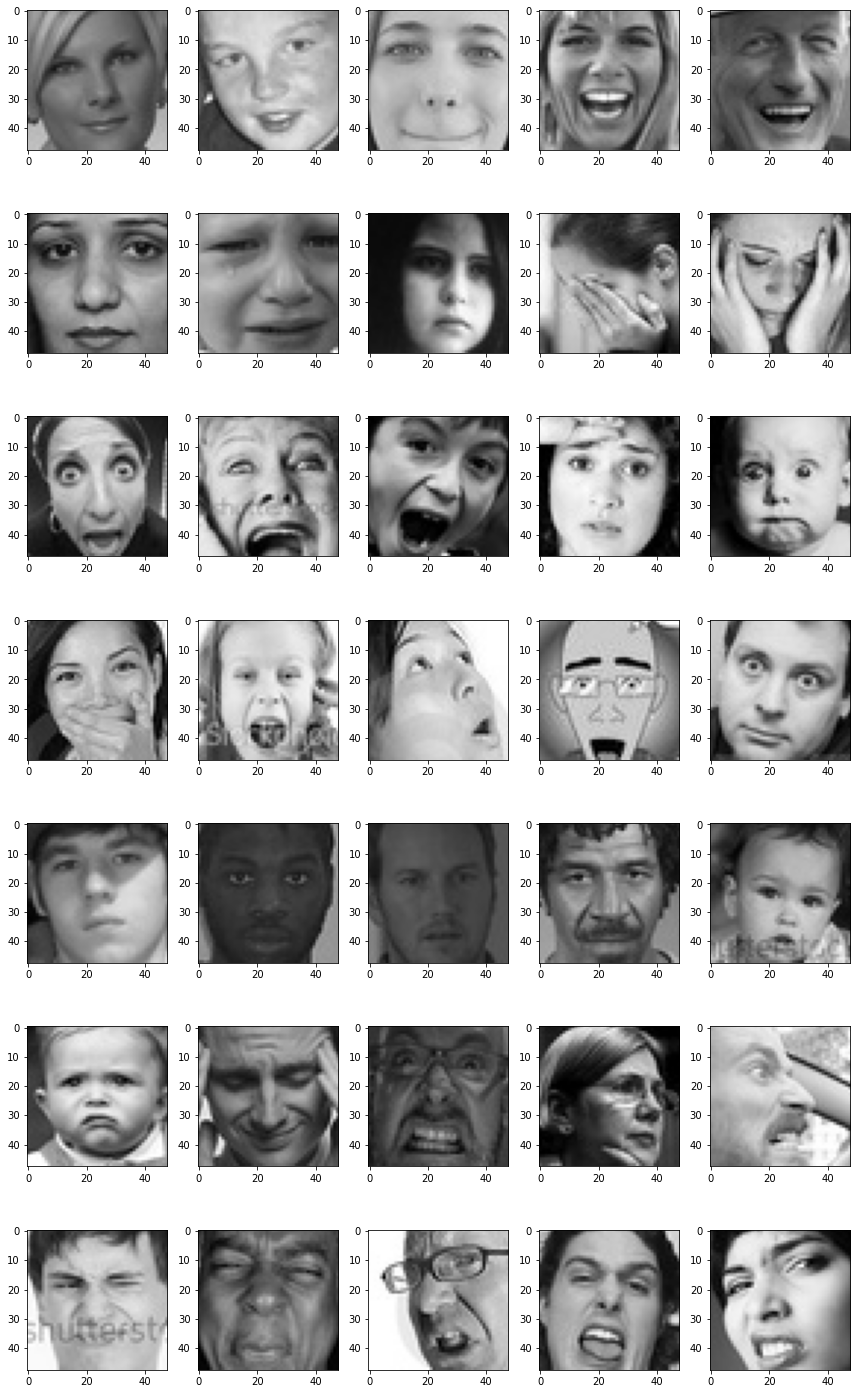

In [9]:
utils.datasets.fer.plot_example_images(plt).show()

In [11]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

7215 happy images
4830 sad images
4097 fear images
3171 surprise images
4965 neutral images
3995 angry images
436 disgust images


### Task 3: Generate Training and Validation Batches

In [12]:
img_size = 48
batch_size = 64

#Creating data-generator for training data
datagen_train = ImageDataGenerator(horizontal_flip = True)

#Creating mini-batches of data from the 'train/' folder
train_generator = datagen_train.flow_from_directory("train/", 
                                                    target_size = (img_size, img_size), 
                                                    color_mode = "grayscale", 
                                                    batch_size = batch_size,
                                                    class_mode = "categorical", 
                                                    shuffle = True)



#Creating data-generator for validation data
datagen_validation = ImageDataGenerator(horizontal_flip = True)

#Creating mini-batches of data from the 'test/' folder
validation_generator = datagen_train.flow_from_directory("test/", 
                                                    target_size = (img_size, img_size), 
                                                    color_mode = "grayscale", 
                                                    batch_size = batch_size,
                                                    class_mode = "categorical", 
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [13]:
model = Sequential()

# 1 - conv block
model.add(Conv2D(64, (3, 3), padding = "same", input_shape = (48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 2 - conv block
model.add(Conv2D(128, (3, 3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 3 - conv block
model.add(Conv2D(512, (3, 3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 4 - conv
model.add(Conv2D(512, (3, 3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation = "softmax"))

opt = Adam(lr=0.0005)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Task 6: Train and Evaluate Model

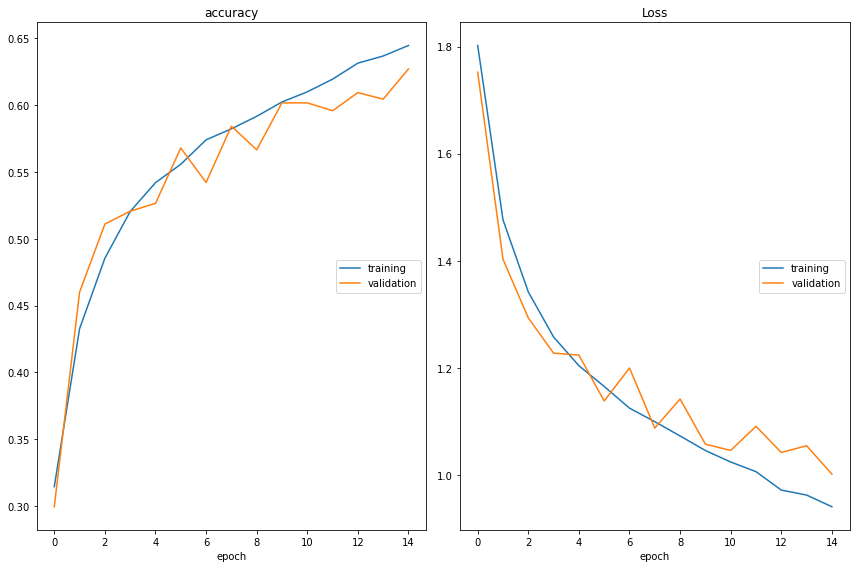

accuracy
	training         	 (min:    0.315, max:    0.645, cur:    0.645)
	validation       	 (min:    0.300, max:    0.627, cur:    0.627)
Loss
	training         	 (min:    0.941, max:    1.802, cur:    0.941)
	validation       	 (min:    1.002, max:    1.752, cur:    1.002)

Epoch 00015: saving model to model_weights.h5
448/448 [==============================] - 198s 441ms/step - loss: 0.9407 - accuracy: 0.6447 - val_loss: 1.0017 - val_accuracy: 0.6271


In [22]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                            save_weights_only = True, mode = 'max', verbose = 1)

#Reducing the learning rate when we don't see improvment after certain number of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 2, min_lr = 0.00001, mode='auto')

callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(x = train_generator, steps_per_epoch = steps_per_epoch, epochs = epochs, validation_data = validation_generator, validation_steps = validation_steps, callbacks = callbacks)

### Task 7: Represent Model as JSON String

In [23]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)